# Bayesian Convolutional Neural Networks

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow_probability.python.layers import DenseVariational, DenseReparameterization, DenseFlipout, Convolution2DFlipout, Convolution2DReparameterization
from tensorflow_probability.python.layers import DistributionLambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU, Convolution2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import *

import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt

%matplotlib inline

print('TensorFlow version:', tf.__version__)
print('TensorFlow Probability version:', tfp.__version__)

TensorFlow version: 2.4.1
TensorFlow Probability version: 0.12.1


### Load MNIST dataset

Loading Fashion MNIST dataset
X_train.shape = (60000, 28, 28, 1)
y_train.shape = (60000, 10)
X_test.shape = (10000, 28, 28, 1)
y_test.shape = (10000, 10)


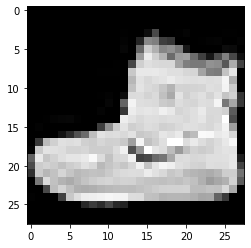

In [2]:
# Hyperparameters
n_class = 10
batch_size = 128
n_epochs = 20
lr = 1e-3

print('Loading Fashion MNIST dataset')
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = np.expand_dims(X_train, -1)
n_train = X_train.shape[0]
X_test = np.expand_dims(X_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, n_class)
y_test = tf.keras.utils.to_categorical(y_test, n_class)

# Normalize data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

plt.imshow(X_train[0, :, :, 0], cmap='gist_gray')
plt.show()

### Define the kernel divergence function that comes with a weight

In [3]:
def get_kernel_divergence_fn(train_size, w=1.0):
    """
    Get the kernel Kullback-Leibler divergence function

    # Arguments
        train_size (int): size of the training dataset for normalization
        w (float): weight to the function

    # Returns
        kernel_divergence_fn: kernel Kullback-Leibler divergence function
    """
    def kernel_divergence_fn(q, p, _):  # need the third ignorable argument
        kernel_divergence = tfp.distributions.kl_divergence(q, p) / tf.cast(train_size, tf.float32)
        return w * kernel_divergence
    return kernel_divergence_fn

In [4]:
# Add a variable "weight" to the layer
def add_kl_weight(layer, train_size, w_value=1.0):
    w = layer.add_weight(name=layer.name+'/kl_loss_weight', shape=(),
                         initializer=tf.initializers.constant(w_value), trainable=False)
    layer.kernel_divergence_fn = get_kernel_divergence_fn(train_size, w)
    return layer

### Define the loss function of negative log-likelihood (input as logits)

In [5]:
def neg_log_likelihood_with_logits(y_true, y_pred):
    y_pred_dist = tfp.distributions.Categorical(logits=y_pred)
    return -tf.reduce_mean(y_pred_dist.log_prob(tf.argmax(y_true, axis=-1)))

### Build and train CNN model

In [6]:
def build_cnn_model(input_shape, train_size):
    model_in = Input(shape=input_shape)
    conv_1 = Convolution2D(32, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_1(model_in)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    conv_2 = Convolution2D(64, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_2(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Flatten()(x)
    dense_1 = Dense(512, activation='relu')
    x = dense_1(x)
    dense_2 = Dense(10, activation=None)
    model_out = dense_2(x)  # logits
    model = Model(model_in, model_out)
    return model
    
cnn_model = build_cnn_model(X_train.shape[1:], n_train)
cnn_model.compile(loss=neg_log_likelihood_with_logits, optimizer=Adam(lr), metrics=['acc'],
                   experimental_run_tf_function=False)
cnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 64)          0     

In [7]:
hist_cnn = cnn_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_split=0.1)

Epoch 1/20
422/422 [==============================] - 5s 6ms/step - loss: 0.6325 - acc: 0.8007 - val_loss: 0.7351 - val_acc: 0.7488
Epoch 2/20
422/422 [==============================] - 2s 5ms/step - loss: 0.2618 - acc: 0.9034 - val_loss: 0.2623 - val_acc: 0.8995
Epoch 3/20
422/422 [==============================] - 2s 5ms/step - loss: 0.1985 - acc: 0.9263 - val_loss: 0.2659 - val_acc: 0.9057
Epoch 4/20
422/422 [==============================] - 2s 5ms/step - loss: 0.1573 - acc: 0.9436 - val_loss: 0.2547 - val_acc: 0.9077
Epoch 5/20
422/422 [==============================] - 2s 5ms/step - loss: 0.1320 - acc: 0.9505 - val_loss: 0.2821 - val_acc: 0.9023
Epoch 6/20
422/422 [==============================] - 2s 5ms/step - loss: 0.1089 - acc: 0.9606 - val_loss: 0.2792 - val_acc: 0.9092
Epoch 7/20
422/422 [==============================] - 2s 5ms/step - loss: 0.0815 - acc: 0.9705 - val_loss: 0.3264 - val_acc: 0.9068
Epoch 8/20
422/422 [==============================] - 2s 5ms/step - loss: 0.

### Build and train the Bayesian CNN model

In [8]:
def build_bayesian_bcnn_model(input_shape, train_size):
    model_in = Input(shape=input_shape)
    conv_1 = Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_1 = add_kl_weight(conv_1, train_size)
    x = conv_1(model_in)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    conv_2 = Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_2 = add_kl_weight(conv_2, train_size)
    x = conv_2(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Flatten()(x)
    dense_1 = DenseFlipout(512, activation='relu',
                           kernel_divergence_fn=None)
    dense_1 = add_kl_weight(dense_1, train_size)
    x = dense_1(x)
    dense_2 = DenseFlipout(10, activation=None,
                           kernel_divergence_fn=None)
    dense_2 = add_kl_weight(dense_2, train_size)
    model_out = dense_2(x)  # logits
    model = Model(model_in, model_out)
    return model
    
bcnn_model = build_bayesian_bcnn_model(X_train.shape[1:], n_train)
bcnn_model.compile(loss=neg_log_likelihood_with_logits, optimizer=Adam(lr), metrics=['acc'],
                   experimental_run_tf_function=False)
bcnn_model.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_flipout (Conv2DFlipou (None, 14, 14, 32)        609       
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 7, 7, 64)          36929     
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
activation_3 (Activation)    (None, 7, 7, 64)          0   

In [9]:
hist_bcnn = bcnn_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_split=0.1)

Epoch 1/20
422/422 [==============================] - 6s 11ms/step - loss: 69.9254 - acc: 0.6365 - val_loss: 65.9720 - val_acc: 0.7693
Epoch 2/20
422/422 [==============================] - 4s 10ms/step - loss: 64.7433 - acc: 0.8017 - val_loss: 60.9216 - val_acc: 0.8270
Epoch 3/20
422/422 [==============================] - 4s 10ms/step - loss: 59.5213 - acc: 0.8342 - val_loss: 55.2350 - val_acc: 0.8392
Epoch 4/20
422/422 [==============================] - 4s 10ms/step - loss: 53.7049 - acc: 0.8520 - val_loss: 49.1650 - val_acc: 0.8508
Epoch 5/20
422/422 [==============================] - 4s 10ms/step - loss: 47.5999 - acc: 0.8592 - val_loss: 43.0280 - val_acc: 0.8478
Epoch 6/20
422/422 [==============================] - 4s 10ms/step - loss: 41.4704 - acc: 0.8715 - val_loss: 37.0551 - val_acc: 0.8623
Epoch 7/20
422/422 [==============================] - 4s 10ms/step - loss: 35.5908 - acc: 0.8753 - val_loss: 31.4991 - val_acc: 0.8638
Epoch 8/20
422/422 [==============================] - 4

### Plot training process

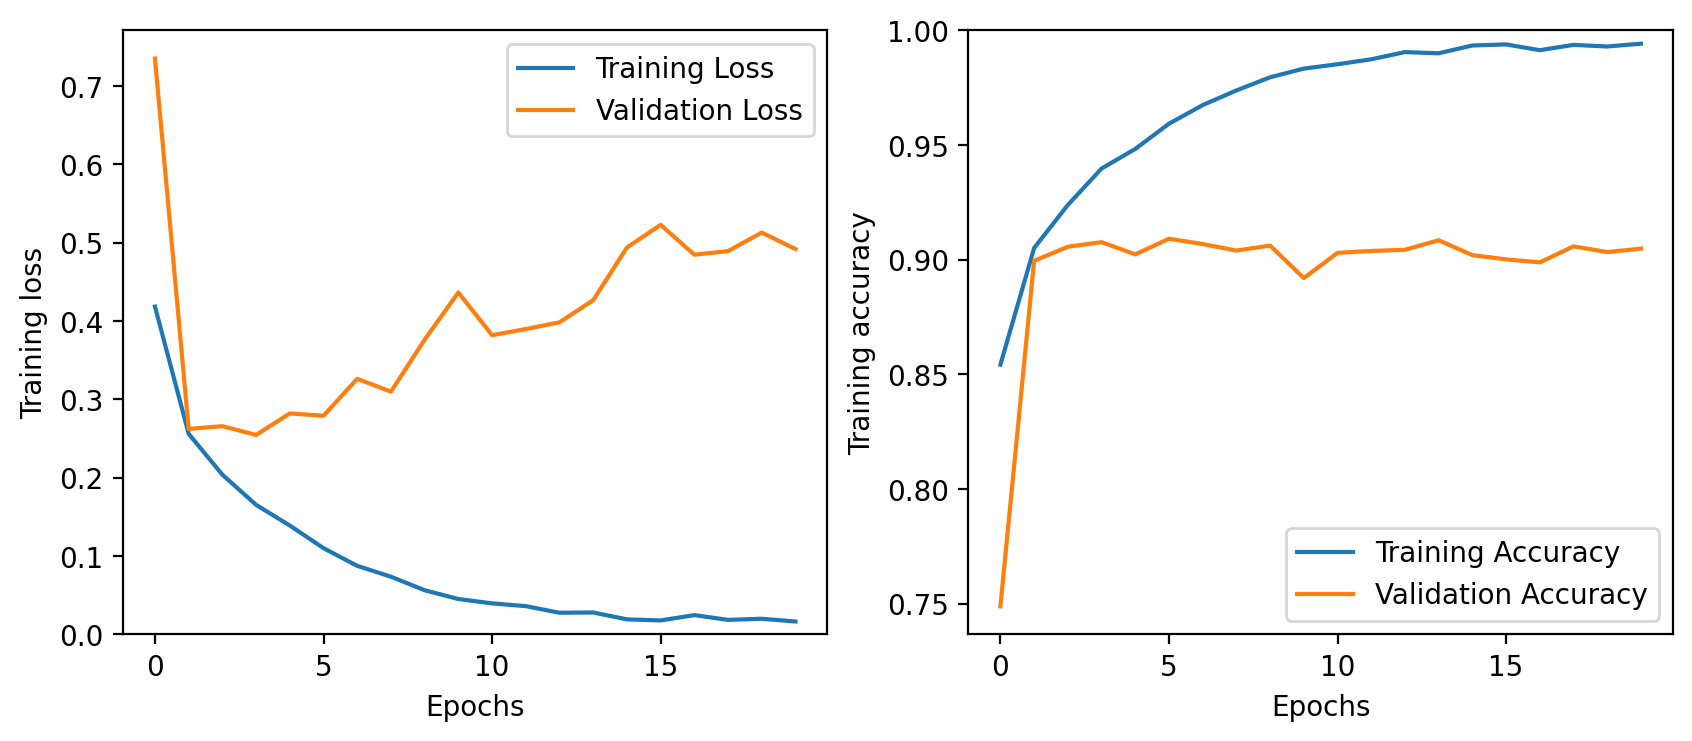

In [10]:
# Frequentist CNN

fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=200)

ax[0].plot(range(n_epochs), hist_cnn.history['loss'], label='Training Loss')
ax[0].plot(range(n_epochs), hist_cnn.history['val_loss'], label='Validation Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training loss')
ax[0].set_ylim([0, None])

ax[1].plot(range(n_epochs), hist_cnn.history['acc'], label='Training Accuracy')
ax[1].plot(range(n_epochs), hist_cnn.history['val_acc'], label="Validation Accuracy")
ax[1].legend()
ax[1].set_ylim([None, 1])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training accuracy')

plt.savefig("CNN_train.pdf", format="pdf", bbox_inches="tight")
plt.show()


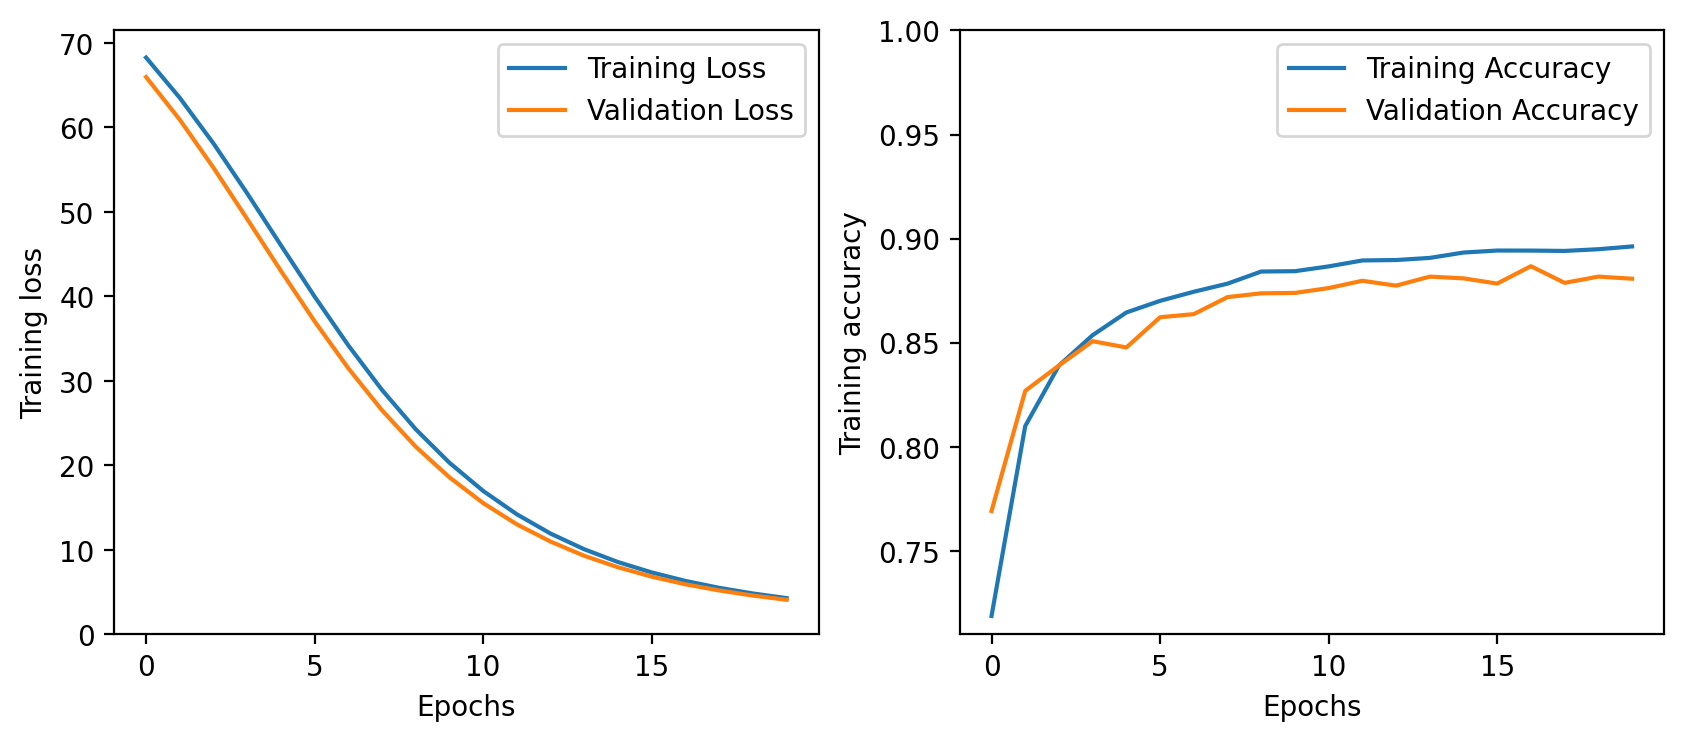

In [11]:
# Bayesian CNN

fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=200)

ax[0].plot(range(n_epochs), hist_bcnn.history['loss'], label='Training Loss')
ax[0].plot(range(n_epochs), hist_bcnn.history['val_loss'], label='Validation Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training loss')
ax[0].set_ylim([0, None])

ax[1].plot(range(n_epochs), hist_bcnn.history['acc'], label='Training Accuracy')
ax[1].plot(range(n_epochs), hist_bcnn.history['val_acc'], label="Validation Accuracy")
ax[1].legend()
ax[1].set_ylim([None, 1])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training accuracy')

plt.savefig("BCNN_train.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Quantify the uncertainty in predictions through sampling

In [12]:
n_mc_run = 100

y_pred_logits_list = np.array([bcnn_model.predict(X_test) for _ in range(n_mc_run)])  # a list of predicted logits

In [13]:
print(X_test.shape)
print(y_pred_logits_list.shape)

print('\ntest sample 0, label = 0, samples:\n', y_pred_logits_list[:10,0,0])
print('\ntest sample 0, label = 7, samples:\n', y_pred_logits_list[:10,0,7])

(10000, 28, 28, 1)
(100, 10000, 10)

test sample 0, label = 0, samples:
 [ -9.241374   -7.123634  -10.031998   -7.119023   -7.0338187  -8.425485
  -5.1532197  -7.4315042  -6.9980865  -8.757159 ]

test sample 0, label = 7, samples:
 [2.228224   1.7117442  4.7530317  3.3907678  3.7998302  0.76067775
 3.318758   3.2404885  1.7495604  3.1467998 ]


In [14]:
med_prob_thres = 0.2 # probability threshold
y_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred = np.array([np.array([int(np.median(y) >= med_prob_thres) for y in y_pred_prob]) for y_pred_prob in y_pred_prob_all])


In [15]:
idx_valid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))

idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on Fashion MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_valid], axis=-1), np.argmax(y_pred[idx_valid], axis=-1))) / len(y_test[idx_valid]))

print('Test accuracy on Fashion MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_invalid], axis=-1), np.argmax(y_pred[idx_invalid], axis=-1))) / len(y_test[idx_invalid]))

Number of recognizable samples: 9994
Unrecognizable samples: [ 635 3229 3265 5012 5561 6874]
Test accuracy on Fashion MNIST (recognizable samples): 0.8884330598359016
Test accuracy on Fashion MNIST (unrecognizable samples): 0.0


### Define the function that plots the histogram of predicted probabilities across all possible classes

In [16]:
def plot_pred_hist(name, y_pred, n_class, n_mc_run, n_bins=30, med_prob_thres=0.2, n_subplot_rows=2, figsize=(20, 7)):
    print('\nmedian of predicted probs = \n', np.median(y_pred, axis=1))
    bins = np.logspace(-n_bins, 0, n_bins+1)
    n_subplot_cols = (n_class + 1) // n_subplot_rows
    fig, ax = plt.subplots(n_subplot_rows, n_subplot_cols, figsize=figsize, dpi=150)
    for i in range(n_subplot_rows):
        for j in range(n_subplot_cols):
            idx = i * n_subplot_cols + j
            if idx < n_class:
                ax[i, j].hist(y_pred[idx], bins)
                ax[i, j].set_xscale('log')
                ax[i, j].set_ylim([0, n_mc_run])
                ax[i, j].title.set_text("{} (median prob: {:.2f}) ({})".format(str(idx),
                                                                               np.median(y_pred[idx]),
                                                                               str(np.median(y_pred[idx]) >= med_prob_thres)))
            else:
                ax[i, j].axis('off')
    fig.subplots_adjust(hspace=0.4)
    plt.savefig(name, format="pdf", bbox_inches="tight")
    plt.show()
    

### A recognizable example

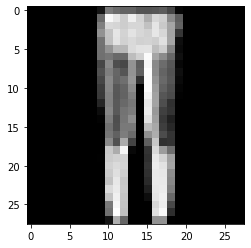

True label of the test sample 3: 1

median of predicted probs = 
 [5.1311119e-11 1.0000000e+00 3.0164790e-12 1.6653749e-08 1.4704142e-10
 1.4505167e-13 8.3815635e-11 4.8365229e-14 2.0184284e-12 6.0808468e-14]


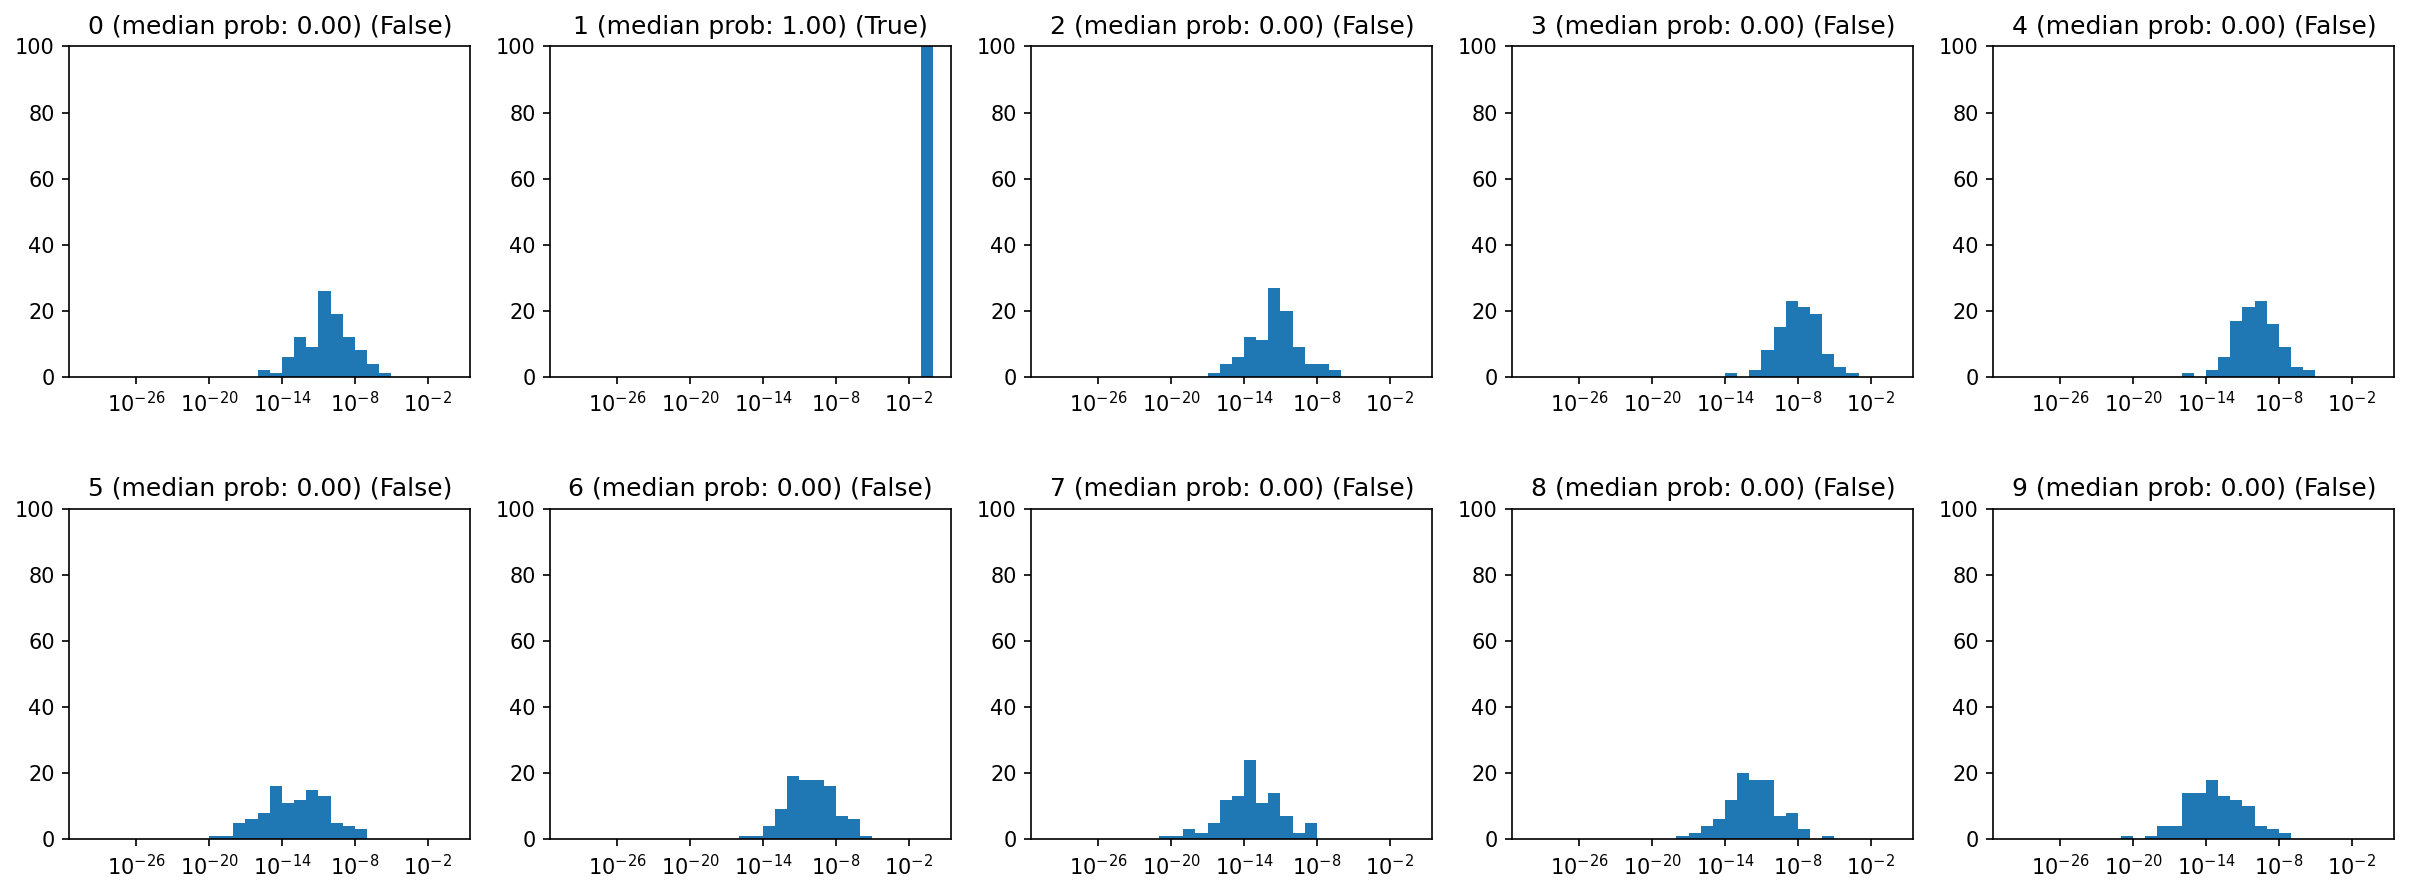

Predicted label of the test sample 3: 1


In [17]:
idx = 3
plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
plt.savefig("familiar_example.pdf", format="pdf", bbox_inches="tight")
plt.show()
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist("familiar_example_confidence.pdf", y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")

### An unrecognizable examples

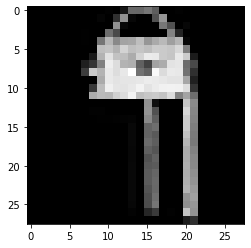

True label of the test sample 635: 8

median of predicted probs = 
 [0.01789987 0.07674253 0.13360095 0.00731399 0.02136724 0.06361249
 0.08711579 0.00223927 0.04366905 0.0070396 ]


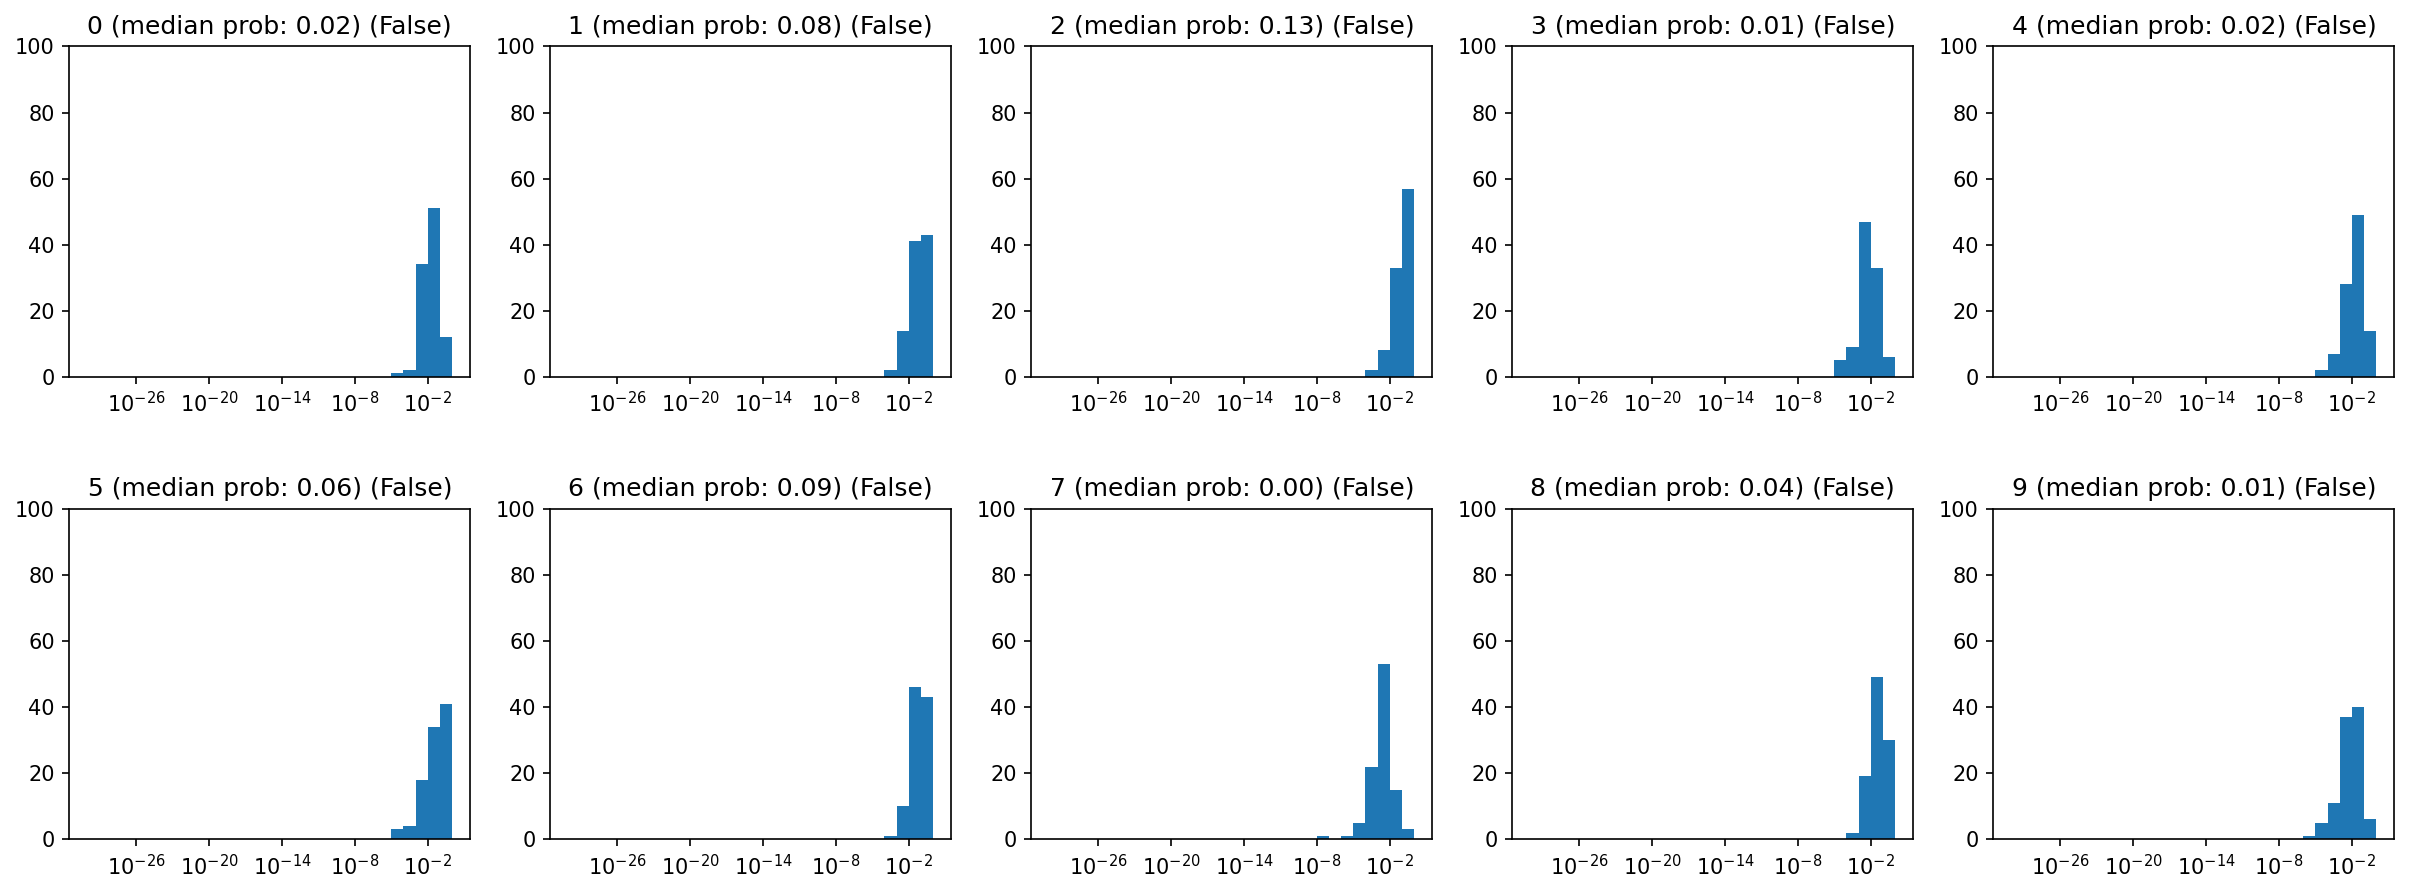

I don't know!


In [25]:
idx = 635
plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
plt.savefig("unfamiliar_example.pdf", format="pdf", bbox_inches="tight")
plt.show()
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist("unfamiliar_example_confidence.pdf", y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")

## Predict non-number images in MNIST dataset

The model is trained to recongnize clothes with confidence. If asked to predict a number image, instead of randomly guessing, the model will not predict. Let's take images in MNIST dataset as an example.

In [19]:
print('Loading MNIST dataset')
_, (X_f_test, y_f_test) = tf.keras.datasets.mnist.load_data()

X_f_test = np.expand_dims(X_f_test, -1)[:1000]
y_f_test = tf.keras.utils.to_categorical(y_f_test, n_class)[:1000]

print("X_f_test.shape =", X_f_test.shape)
print("y_f_test.shape =", y_f_test.shape)

Loading MNIST dataset
X_f_test.shape = (1000, 28, 28, 1)
y_f_test.shape = (1000, 10)


### Quantify uncertainty

In [20]:
n_mc_run = 100

y_f_pred_logits_list = np.array([bcnn_model.predict(X_f_test) for _ in range(n_mc_run)])  # a list of predicted logits

In [21]:
print(X_f_test.shape)
print(y_f_pred_logits_list.shape)

print('\ntest sample 0, label = 0, samples:\n', y_f_pred_logits_list[:10,0,0])
print('\ntest sample 0, label = 7, samples:\n', y_f_pred_logits_list[:10,0,7])

(1000, 28, 28, 1)
(100, 1000, 10)

test sample 0, label = 0, samples:
 [-1210.3792 -1827.3448  -594.3561 -1840.2587 -1219.2882   843.0986
  -630.5922  -569.4788  1300.0277  -529.2087]

test sample 0, label = 7, samples:
 [-2755.455     553.13434 -1523.4103   -279.06412 -1196.7258  -1832.2662
  2126.5015  -1719.6664   -602.29626 -2318.8005 ]


In [22]:
med_prob_thres = 0.2 # probability threshold
y_f_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_f_pred_logits_list], axis=-1)
y_f_pred = np.array([np.array([int(np.median(y) >= med_prob_thres) for y in y_f_pred_prob]) for y_f_pred_prob in y_f_pred_prob_all])

In [23]:
idx_f_valid = [any(y) for y in y_f_pred]
print('Number of recognizable samples:', sum(idx_f_valid))
# print('Recognizable samples:', np.where(idx_f_valid)[0])

idx_f_invalid = [not any(y) for y in y_f_pred]
print('Number of unrecognizable samples:', sum(idx_f_invalid))
print('\n10 unrecognizable samples:', np.where(idx_f_invalid)[0][:10])

print('\nTest accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_f_test[idx_f_valid], axis=-1), np.argmax(y_f_pred[idx_f_valid], axis=-1))) / len(y_f_test[idx_f_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_f_test[idx_f_invalid], axis=-1), np.argmax(y_f_pred[idx_f_invalid], axis=-1))) / len(y_f_test[idx_f_invalid]))

Number of recognizable samples: 24
Number of unrecognizable samples: 976

10 unrecognizable samples: [0 1 2 3 4 5 6 7 8 9]

Test accuracy on MNIST (recognizable samples): 0.375
Test accuracy on MNIST (unrecognizable samples): 0.08299180327868852


### An  unrecognizable example

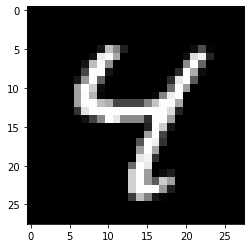

True label of the test sample 6: 4

median of predicted probs = 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


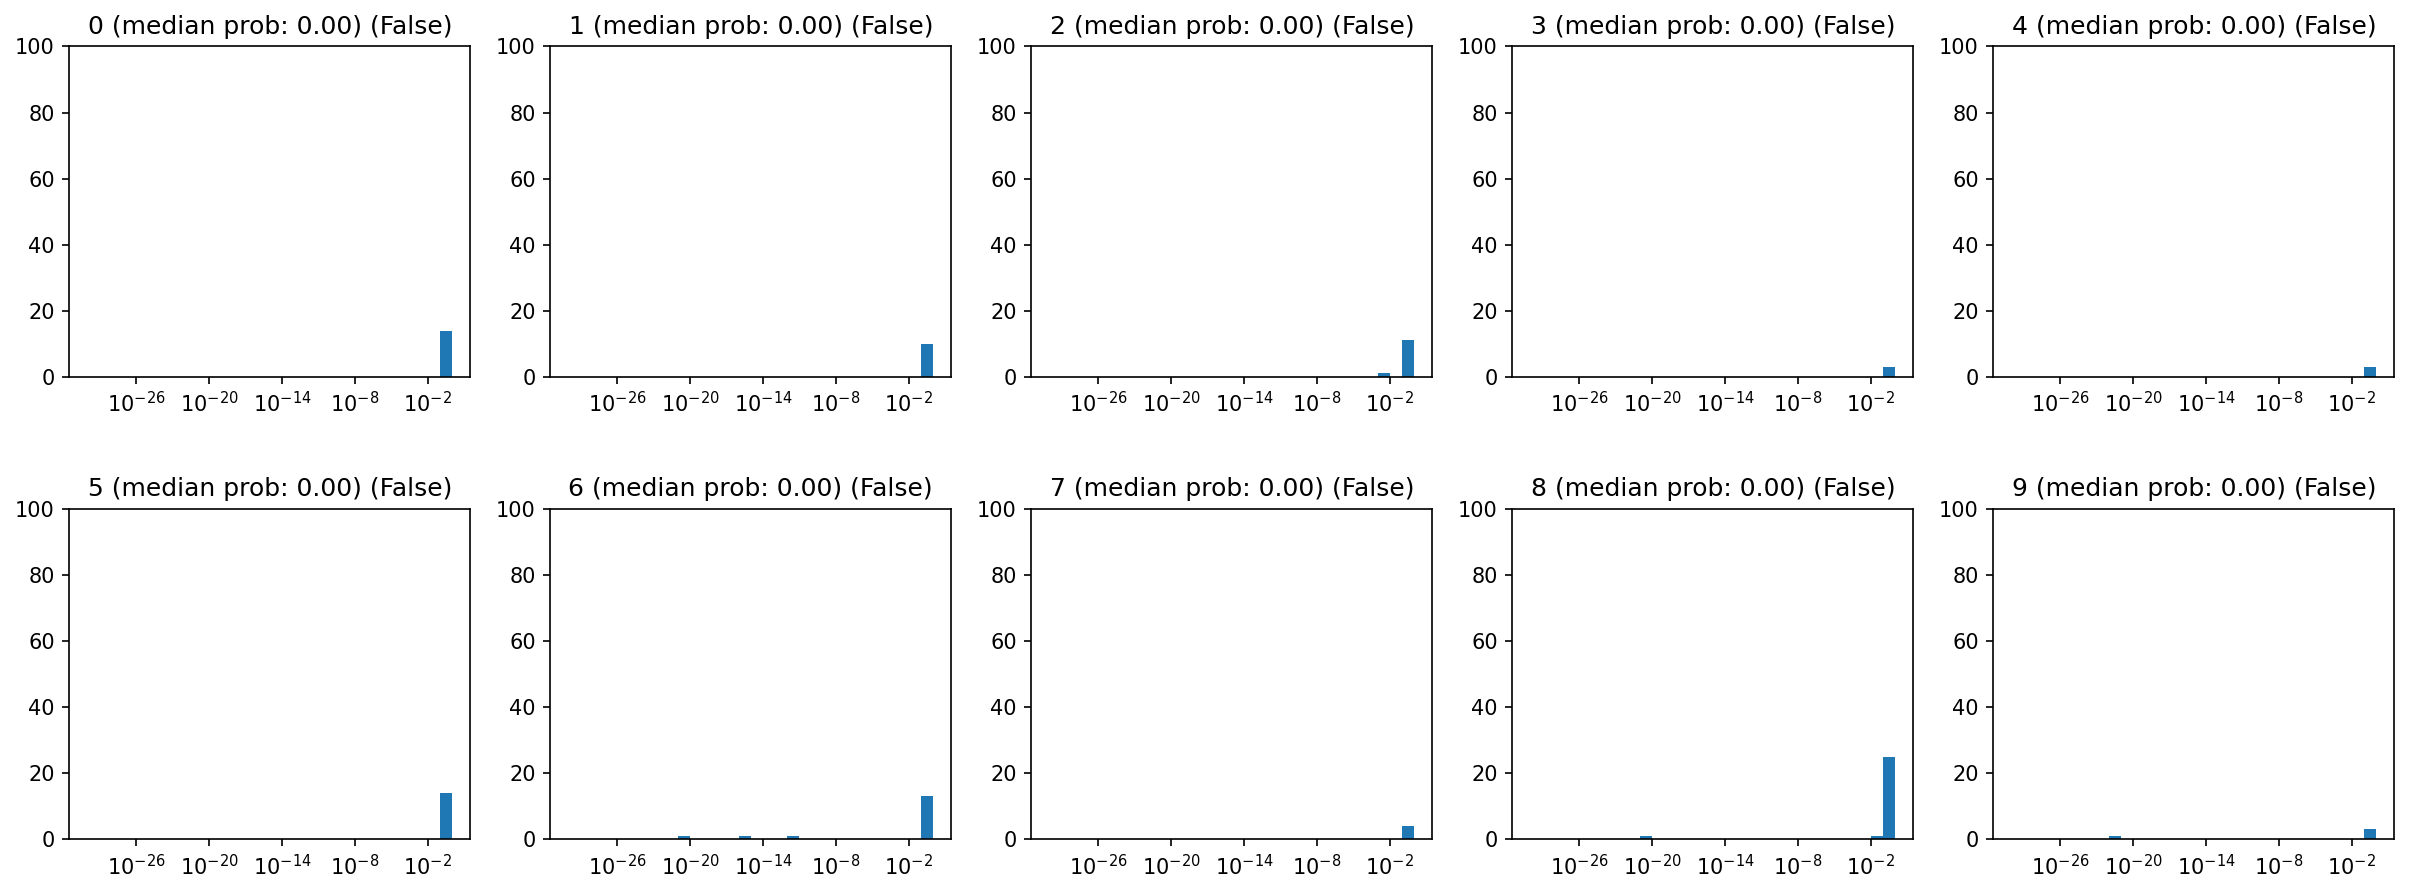

I don't know!


In [24]:
idx = 6
plt.imshow(X_f_test[idx, :, :, 0], cmap='gist_gray')
plt.savefig("MNIST_digit.pdf", format="pdf", bbox_inches="tight")
plt.show()
print("True label of the test sample {}: {}".format(idx, np.argmax(y_f_test[idx], axis=-1)))

plot_pred_hist("mnist_confidence.pdf", y_f_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_f_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")